In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated, bayesian_optimization, init_sampling
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

import torch

## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [2]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

In [3]:
true_min = [6.936e-03, 2.021e-02, 4.000e-02]

### Campaign structure 

### 2. Calculate scattering

In [4]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [5]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [6]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

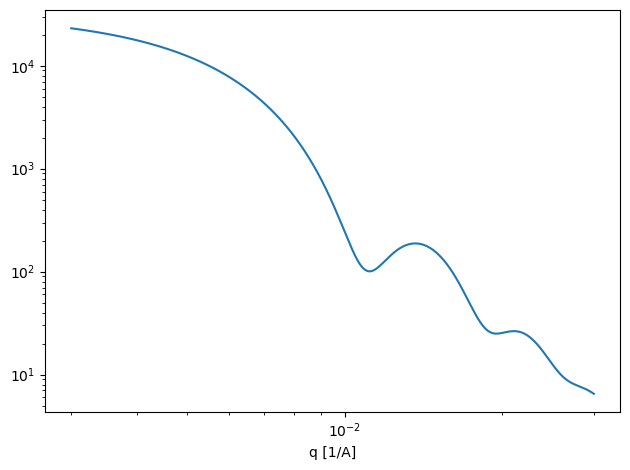

In [7]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [8]:
trials = {'qLogNEI_Noyvar':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':0.05,
            'characterization':'SAXS',
            'distance':'apdist',
            'yvar':False,
            'acqf':'qLogNEI'
        },
        'qLogEI_yvar':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':0.05,
            'characterization':'SAXS',
            'distance':'apdist',
            'yvar':True,
            'acqf':'qLogEI'
        },
        'qLogEI_noYvar':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':0.05,
            'characterization':'SAXS',
            'distance':'apdist',
            'yvar':False,
            'acqf':'qLogEI'
        },
}


In [9]:
var_test_points = [[0.007, 0.02, 0.04], [0.09, 0.006, 0.14], [0.08, 0.099, 0.08]]

In [10]:
def estimate_variance(var_test_points, target_I, q_grid, amplitude_weight, noise_level, characterization, distance_metric, pdi_weight, target_d, target_pdi, n_rep = 10):
    variances = []
    for point in var_test_points:
        uuid_val = 'null'
        sample = {'teos_vol_frac':point[0], 'ammonia_vol_frac':point[1], 'water_vol_frac':point[2]}

        samples_list = []
        distances = []
        for i in range(n_rep):
            _, samp = execute.process_sample(uuid_val, sample, target_I, q_grid, amplitude_weight, noise_level, characterization =  characterization, distance_metric = distance_metric, pdi_weight = pdi_weight, target_d = target_d, target_pdi = target_pdi)
            samples_list.append(samp)
            distances.append(samp['distance'])

        var = np.var(distances)
        variances.append(var)

    return np.mean(variances)
            
        

In [16]:
def acqf_contour(acq_func, fixed_dim, fixed_val, x_range, y_range):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    return acq_func_values

Estimated y variance:  None
Running optimization for trial qLogNEI_Noyvar
### Replicate 0 ###
starting initial samples
batch distance metric:  apdist
starting batch 1
Optimized acqf in 6.489843845367432 s
batch distance metric:  apdist
starting batch 2
Optimized acqf in 22.268513679504395 s
batch distance metric:  apdist
starting batch 3
Optimized acqf in 2.7324042320251465 s
batch distance metric:  apdist
starting batch 4
Optimized acqf in 9.921199321746826 s
batch distance metric:  apdist
starting batch 5
Optimized acqf in 51.272995710372925 s
batch distance metric:  apdist
starting batch 6
Optimized acqf in 17.875473976135254 s
batch distance metric:  apdist
starting batch 7
Optimized acqf in 29.270556926727295 s
batch distance metric:  apdist
starting batch 8
Optimized acqf in 11.35288381576538 s
batch distance metric:  apdist
starting batch 9
Optimized acqf in 40.46243405342102 s
batch distance metric:  apdist
starting batch 10
Optimized acqf in 32.0509774684906 s
batch distance m

/home/ubuntu/miniconda3/envs/botorch/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


starting batch 1
Optimized acqf in 5.8790082931518555 s
batch distance metric:  apdist
starting batch 2
Optimized acqf in 10.428530216217041 s
batch distance metric:  apdist
starting batch 3
Optimized acqf in 5.412133693695068 s
batch distance metric:  apdist
starting batch 4
Optimized acqf in 5.467043161392212 s
batch distance metric:  apdist
starting batch 5
Optimized acqf in 5.529600620269775 s
batch distance metric:  apdist
starting batch 6
Optimized acqf in 10.194576740264893 s
batch distance metric:  apdist
starting batch 7
Optimized acqf in 24.058918237686157 s
batch distance metric:  apdist
starting batch 8
Optimized acqf in 15.281872272491455 s
batch distance metric:  apdist
starting batch 9
Optimized acqf in 34.92831826210022 s
batch distance metric:  apdist
starting batch 10
Optimized acqf in 31.50451397895813 s
batch distance metric:  apdist
starting batch 11
Optimized acqf in 22.754600048065186 s
batch distance metric:  apdist
starting batch 12
Optimized acqf in 35.1122798

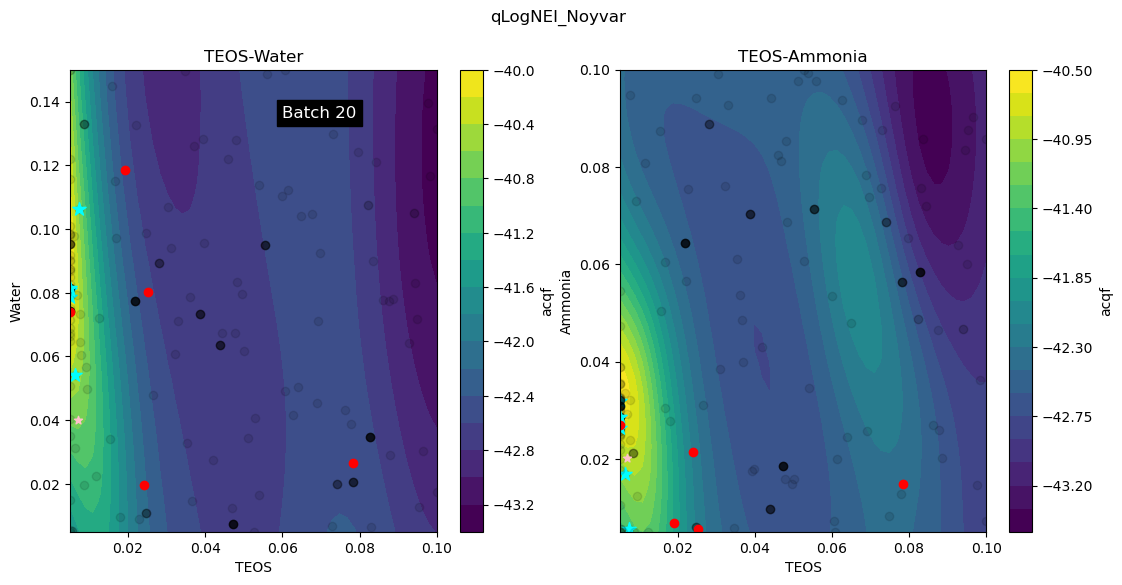

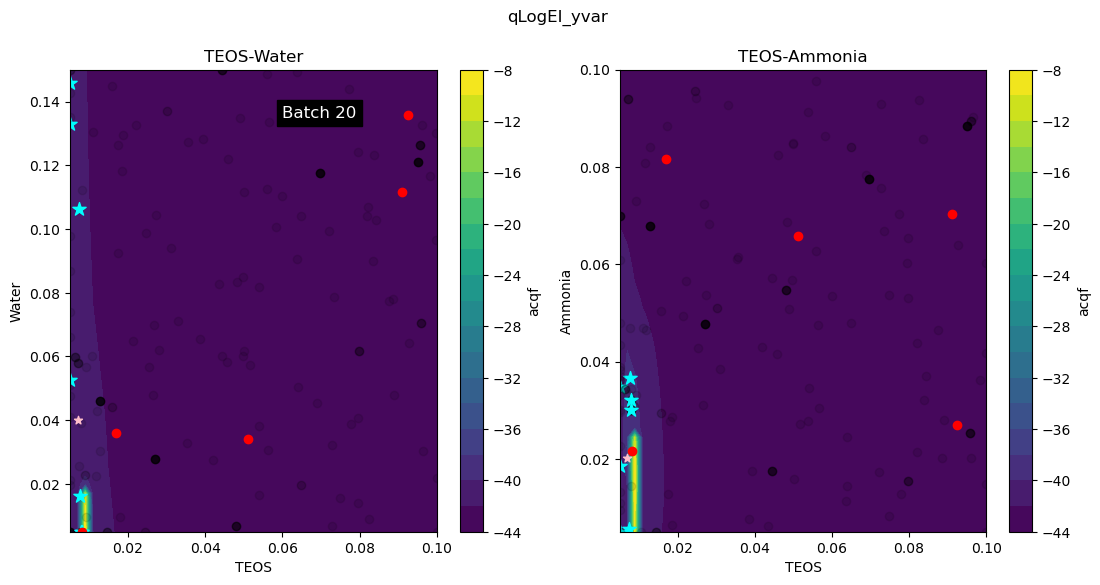

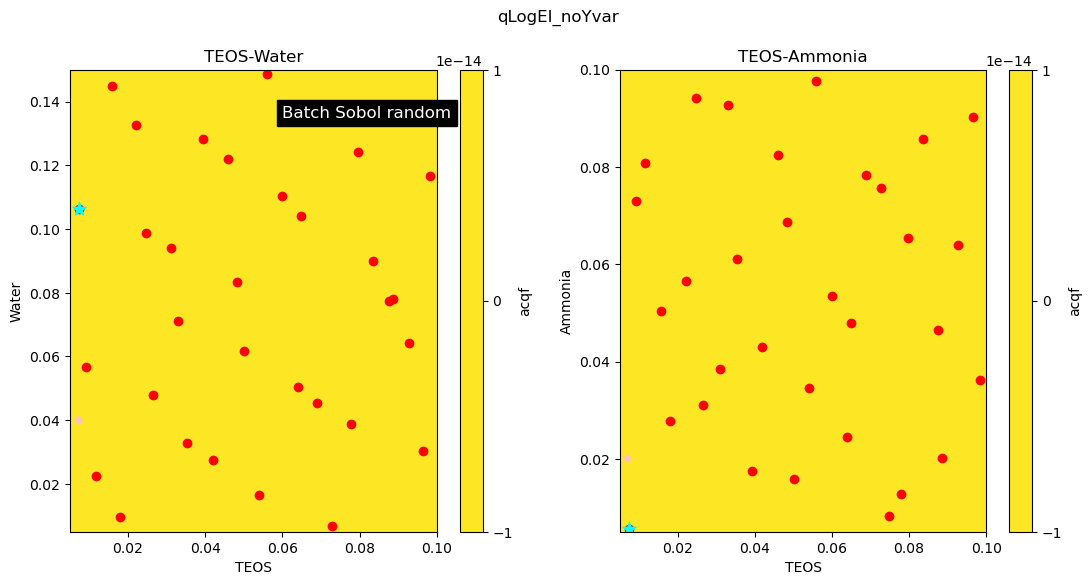

In [17]:
budget = 100
n_replicates = 1
sobol_seed = 42
NUM_RESTARTS = 50
RAW_SAMPLES = 512
nu = 5/2
ard_num_dims = 3
target_d = target_r_nm*2
n_grid = 50

convergence_threshold = 0.05



for trial_name, params in trials.items():
    
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']
    characterization = params['characterization']
    distance_metric = params.get('distance', None)
    pdi_weight = params.get('pdi_weight', None)
    y_var_flag = params['yvar']
    acqf_name = params['acqf']


    if y_var_flag:
        y_var = estimate_variance(var_test_points, target_I, q_grid, amplitude_weight, noise_level, characterization, distance_metric, pdi_weight, target_d, target_pdi, n_rep = 10)
    else:
        y_var = None
    print('Estimated y variance: ', y_var)
    target_d = target_r_nm*2

    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(budget/batch_size))
    
    bounds_torch_norm = torch.tensor([(lower_bounds[0], upper_bounds[0]), (lower_bounds[1], upper_bounds[1]), (lower_bounds[2], upper_bounds[2])]).transpose(-1, -2)
    bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

    print(f'Running optimization for trial {trial_name}')
    for rep_num in range(n_replicates):
        print(f'### Replicate {rep_num} ###')

        print('starting initial samples')
        initial_samples = init_sampling.sobol_sample(m_samples, sobol_seed, lower_bounds, upper_bounds)
        
        # 2. 'measure' sobol samples
        
        execute.batch_experiment(initial_samples, target_I, q_grid, amplitude_weight, noise_level, characterization, pdi_weight, distance_metric, target_d, target_pdi)
        
        # 3. start experiment loop:
        data = initial_samples
        models = []
        acqfs = []
        train_x_list = []
        train_y_list = []
        candidates_raw_list = []
        candidates_list = []
        for i in range(n_batches):
            print(f'starting batch {i+1}')
            # 3a. Prepare and run BO
            x_train, y_train = bayesian_optimization.bo_preprocess(data, bounds_torch_norm)
            candidates, model, train_x, train_y, acqf = bayesian_optimization.bayesian_optimize(x_train, y_train, batch_size, NUM_RESTARTS, RAW_SAMPLES, nu, ard_num_dims, bounds_torch_opt, bounds_torch_norm, return_model = True, y_var_scale = y_var, acqf = acqf_name)
            candidates_raw = candidates
            candidates = bayesian_optimization.bo_postprocess(candidates)
            models.append(model)
            acqfs.append(acqf)
            train_x_list.append(train_x)
            train_y_list.append(train_y)
            candidates_raw_list.append(candidates_raw)
            candidates_list.append(candidates)
        
            # run experiment
            execute.batch_experiment(candidates, target_I, q_grid, amplitude_weight, noise_level, characterization, pdi_weight, distance_metric, target_d, target_pdi)
        
            # update running data tally
            for uuid_val, sample in candidates.items():
                data[uuid_val] = sample

        # save model objects for post processing
        with open(f'{trial_name}_replicate_{rep_num}.pkl', 'wb') as f:
            pickle.dump(data, f)

        with open(f'{trial_name}_models.pkl', 'wb') as f:
            pickle.dump(models, f)
            
        with open(f'{trial_name}_acqfs.pkl', 'wb') as f:
            pickle.dump(acqfs, f)
        
        with open(f'{trial_name}_train_x_list.pkl', 'wb') as f:
            pickle.dump(train_x_list, f)
            
        with open(f'{trial_name}_train_y_list.pkl', 'wb') as f:
            pickle.dump(train_y_list, f)
            
        with open(f'{trial_name}_candidates_raw.pkl', 'wb') as f:
            pickle.dump(candidates_raw_list, f)
            
        with open(f'{trial_name}_candidates.pkl', 'wb') as f:
            pickle.dump(candidates_list, f)
        
        # get contour plot working
        acqf_contours_water = []
        acqf_contours_ammonia = []
        
        x = np.linspace(0, 1, n_grid)
        y = np.linspace(0, 1, n_grid)
        z = np.linspace(0, 1, n_grid)

        data_complete, data_batches, best_distances_list, best_uuids_list, converge_iterations, converge_uuid, best_composition_dist, name_bounds = post_process.process_distances(trial_name, params, true_min, n_replicates = n_replicates, convergence_threshold = convergence_threshold)
        
        for acqf in acqfs:
            contour_water = acqf_contour(acqf, 2, true_min[2], x, y)
            acqf_contours_water.append(contour_water)
        
            contour_ammonia = acqf_contour(acqf, 1, true_min[1], x, y)
            acqf_contours_ammonia.append(contour_ammonia)
        
        
        with open(f'{trial_name}_acqf_contours_water.pkl', 'wb') as f:
            pickle.dump(acqf_contours_water, f)
        
        with open(f'{trial_name}_acqf_contours_ammonia.pkl', 'wb') as f:
            pickle.dump(acqf_contours_ammonia, f)

        acqf_contours_init = np.zeros_like(acqf_contours_ammonia[0])
        acqf_contours_water.insert(0, acqf_contours_init)
        acqf_contours_ammonia.insert(0, acqf_contours_init)
        
        ammonia = np.linspace(lower_bounds[1], upper_bounds[1], n_grid)
        water = np.linspace(lower_bounds[2], upper_bounds[2], n_grid)
        teos = np.linspace(lower_bounds[0], upper_bounds[0], n_grid)
        
        anim = contour_animated.ContourAnimation(ammonia, water, teos, acqf_contours_ammonia, acqf_contours_water, 
                                data_batches[0], best_uuids_list[0], n_batches, true_min, trial_name, n_grid, m_samples, batch_size, cbar_label = 'acqf')
        
        anim.save(f"{trial_name}_acqf_contour.html", format="html")  # Saves as an HTML file
            

In [63]:
data_complete, data_batches, best_distances_list, best_uuids_list, converge_iterations, converge_uuid, best_composition_dist, name_bounds = post_process.process_distances(trial_name, params, true_min, n_replicates = n_replicates, convergence_threshold = convergence_threshold)

In [15]:

for trial_name, params in trials.items():

    with open(f"{trial_name}_models.pkl", 'rb') as f:
        models = pickle.load(f)

    with open(f"{trial_name}_train_x_list.pkl", 'rb') as f:
        train_x_list = pickle.load(f)

    with open(f"{trial_name}_train_y_list.pkl", 'rb') as f:
        train_y_list = pickle.load(f)

    print('########################################')
    print(trial_name)
    print('########################################')
    i = 0
    for model, train_x, train_y in zip(models, train_x_list, train_y_list):
    
        print(model.covar_module.lengthscale)
        posterior = model.posterior(train_x)
        #mean = np.array(posterior.mean.detach().reshape(-1))
        #std = np.array(posterior.stddev.detach().reshape(-1))
    
        #fig, ax = plt.subplots(figsize = (6,6))
    
        #ax.errorbar(np.array(train_y), mean, yerr = std, linestyle = '', marker = '.')
        #ax.plot(train_y, train_y)
        #ax.set_xlabel('True scaled distance')
        #ax.set_ylabel('Predicted scaled distance')
        #ax.text(0.1, 0.9, f'Iteration {i+1}')
        i += 1

########################################
qLogNEI_Noyvar
########################################
tensor([[0.1526, 0.3795, 1.1209]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.1630, 0.5547, 1.6894]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.1754, 0.6073, 0.6153]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2048, 0.7318, 0.8872]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.1861, 0.4968, 0.5279]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2127, 0.6027, 0.7404]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2120, 0.5705, 0.6867]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2147, 0.5423, 0.7952]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2165, 0.5112, 0.4676]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
tensor([[0.2236, 0.5341, 0.4752]], dtype=torch.float64,
       grad_fn=<Sof

In [14]:
train_y

qLogNoisyExpectedImprovement(
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
  (sampler): SobolQMCNormalSampler()
  (objective): GenericMCObjective()
  (base_sampler): SobolQMCNormalSampler()
)

In [54]:
# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    acq_func_values = acqf_contour(acq_func, fixed_dim, fixed_val, x_range, y_range)

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

In [46]:
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()


In [59]:
n_grid = 50

In [79]:
acqf_contours_water = []
acqf_contours_ammonia = []

x = np.linspace(0, 1, n_grid)
y = np.linspace(0, 1, n_grid)
z = np.linspace(0, 1, n_grid)

for acqf in acqfs:
    contour_water = acqf_contour(acqf, 2, true_min[2], x, y)
    acqf_contours_water.append(contour_water)

    contour_ammonia = acqf_contour(acqf, 1, true_min[1], x, y)
    acqf_contours_ammonia.append(contour_ammonia)
    

In [80]:
acqf_contours_init = np.zeros_like(acqf_contours_ammonia[0])

In [81]:
acqf_contours_water.insert(0, acqf_contours_init)
acqf_contours_ammonia.insert(0, acqf_contours_init)

In [82]:
ammonia = np.linspace(lower_bounds[1], upper_bounds[1], n_grid)
water = np.linspace(lower_bounds[2], upper_bounds[2], n_grid)
teos = np.linspace(lower_bounds[0], upper_bounds[0], n_grid)

Animation saved as acqf_contour.html


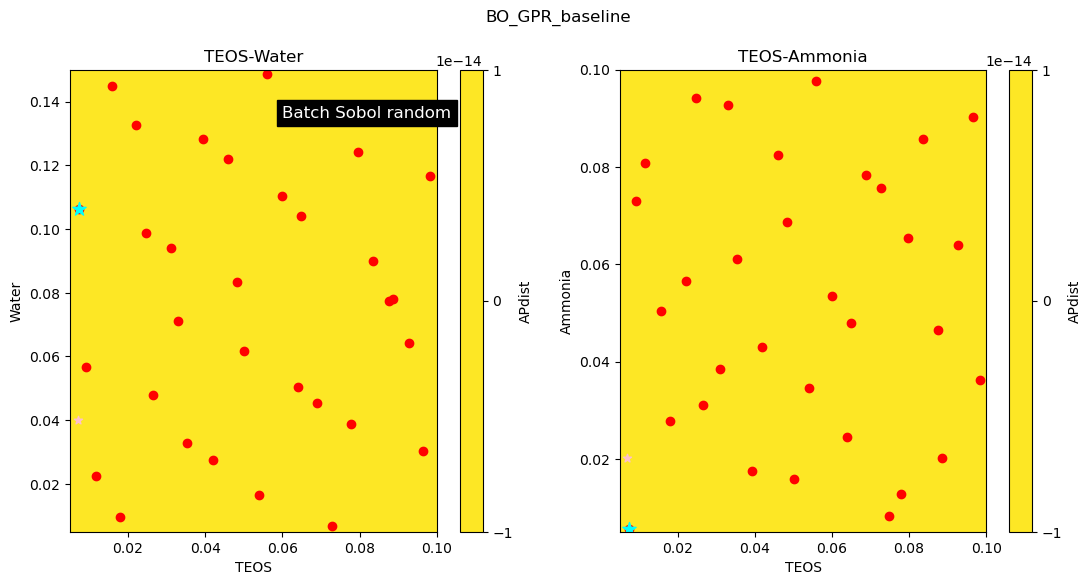

In [92]:
anim = contour_animated.ContourAnimation(ammonia, water, teos, acqf_contours_ammonia, acqf_contours_water, 
                        data_batches[0], best_uuids_list[0], n_batches, true_min, trial_name, n_grid, m_samples, batch_size)

anim.save(f"acqf_contour.html", format="html")  # Saves as an HTML file

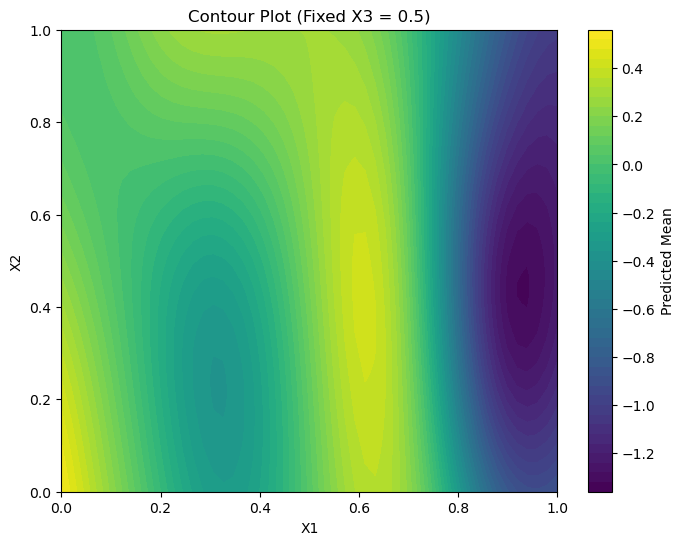

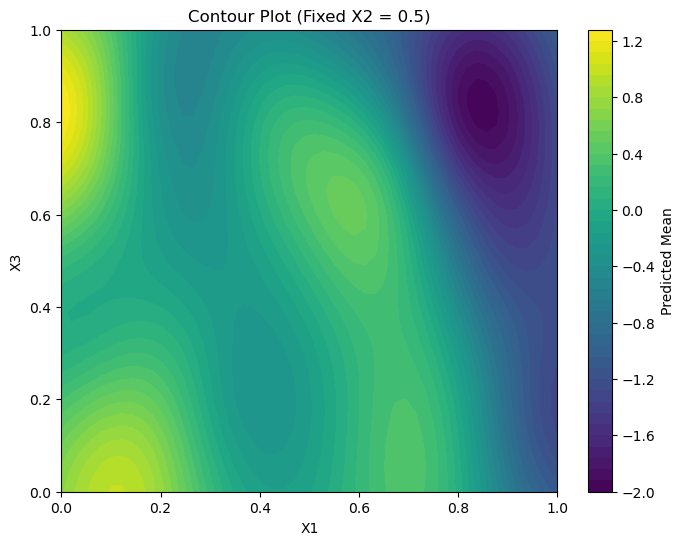

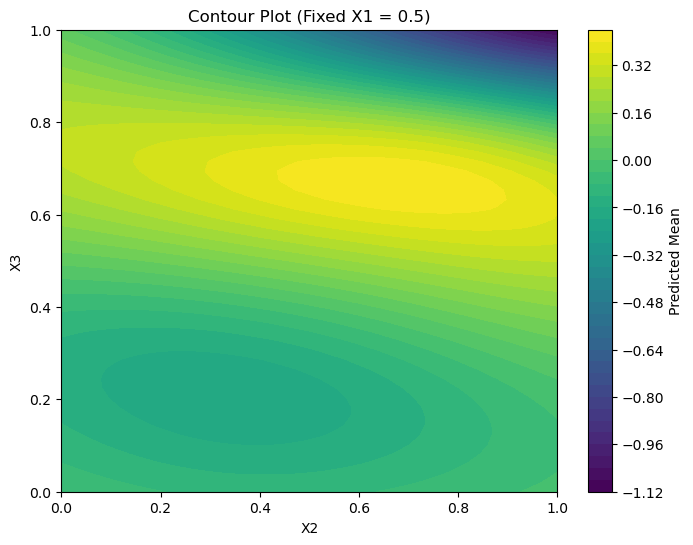

In [50]:
model_nei = models[-1]

# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")

In [48]:
# compare to true